In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Relaxation in 2D ###

We looked at a relaxation method for the 1D Poisson equation.  Here's let's do a 2D case where we have Dirichlet boundary conditions ($\Phi(x,y)=0$ on the boundary) and a source.  For ease we'll take our computational domain to be the unit square, with $N_g$ points in each dimension of spacing $h=1/N_g$.  Label our discretized potential and charge density as $\Phi_{ij}$ and $\rho_{ij}$ respectively.

We'll use the lowest order approximation to the Laplacian, so that
$$
  \nabla_{2D}^2\Phi_{ij} = \frac{1}{h^2}
  \left[\begin{array}{ccc} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{array}\right]
  \Phi_{ij}
$$
in a hopefully-understandable shorthand.

Relaxation proceeds by starting with some initial $\Phi^{\rm old}$ and then iterating:
$$
  \Phi^{\rm new}_{ij} = \frac{1}{4}
  \left[\begin{array}{ccc} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{array}\right]
  \Phi^{\rm old}_{ij} + \pi h^2 \rho_{ij}
$$
We update all interior points, but not any "boundary" points (which are fixed to $\Phi=0$ in our problem).

For an introduction we shall take $\rho_{ij}$ to be just off-center and fall rapidly to zero by the boundaries. 

In [2]:
# Set up our grid, and give ourselves some X and Y coordinate axes:
Ng = 64
hh = 1.0/Ng
h2 = hh**2
X,Y= np.meshgrid(np.linspace(0,1,Ng),np.linspace(0,1,Ng),indexing='ij')

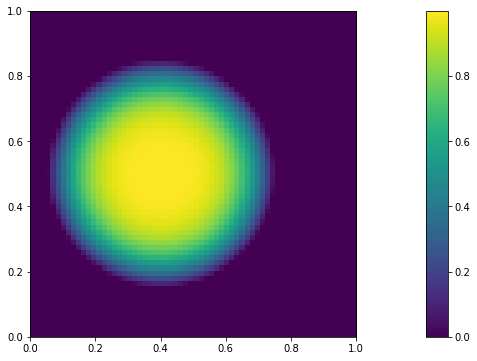

In [3]:
# Set up a charge density that falls smoothly to zero by the boundaries.
# Almost anything will do here.
r2  = (X-0.4)**2+(Y-0.5)**2
rho = np.cos( 4*np.pi*r2 )
rho[rho<0.0]=0
rho[r2 >0.3]=0
# Plot it:
fig,ax = plt.subplots(1,2,figsize=(8,6),gridspec_kw={'width_ratios':[5,1]})
im = ax[0].imshow(rho.T,origin='lower',extent=[0,1,0,1])
plt.colorbar(im,cax=ax[-1])
ax[-1].set_aspect(15)

In [12]:
def solve(Niter=10):
    """Does Jacobi iteration to solve for Phi."""
    # Start with all zeros.
    old = np.zeros( (Ng,Ng) )
    new = np.zeros_like(old)
    # Now do "Niter" updates.
    for iter in range(Niter):
        # We code the update as loops, which is super slow in Python
        # but is probably the easiest to read.  Note that we don't
        # update the boundaries (at ix=0, ix=Ng-1, iy=0 and iy=Ng-1).
        for ix in range(1,Ng-1):
            for iy in range(1,Ng-1):
                new[ix,iy] = 0.25*(old[ix,iy-1]+old[ix-1,iy]+old[ix+1,iy]+old[ix,iy+1])
                new[ix,iy]+= np.pi * h2 * rho[ix,iy]
        old = new.copy()
    return(new)

Phi in range [  0.0000e+00,  5.2194e-01]


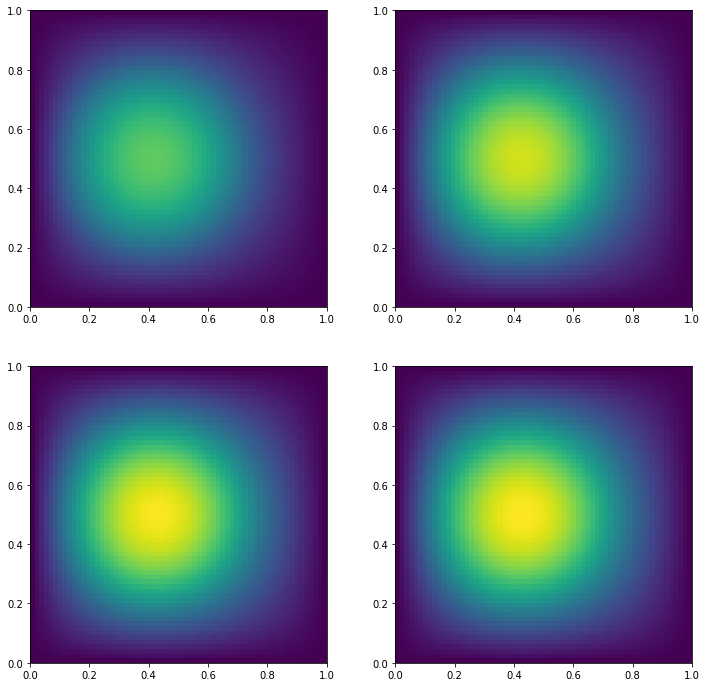

In [9]:
#
# Take a look at the convergence: this takes quite a while to run!
#
phi = []
for iter in [1024,2048,4096,8192]:
    phi.append( solve(iter) )
pmin,pmax = np.min(phi[-1]),np.max(phi[-1])
print("Phi in range [{:12.4e},{:12.4e}]".format(pmin,pmax))
# Now show the solution for a several different numbers of iterations.
fig,ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].imshow(phi[0].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)
ax[0,1].imshow(phi[1].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)
ax[1,0].imshow(phi[2].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)
ax[1,1].imshow(phi[3].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)

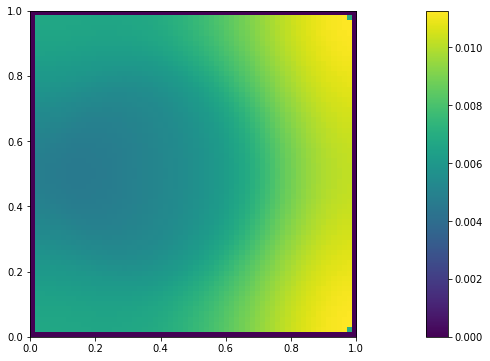

In [10]:
# Let's plot the fractional difference between the last two iterations:
ratio  = np.abs(phi[-1]-phi[-2])/phi[-1].clip(1e-3,1e3)
#
fig,ax = plt.subplots(1,2,figsize=(8,6),gridspec_kw={'width_ratios':[5,1]})
im = ax[0].imshow(ratio.T,origin='lower',extent=[0,1,0,1])
plt.colorbar(im,cax=ax[-1])
ax[-1].set_aspect(15)

So we see that the convergence is good to about a percent in $\Phi$ and it's substantially better than that where $\Phi$ is large.  This is pretty good!

### Square capacitors ###

We discussed variational methods for finding $\Phi$ in problem sets, and how one could use energy arguments (minimizing $W[\Phi]$) to compute capacitance.  Let's consider finding $C$ for a capacitor made out of two square pipes which are concentric (and infinitely extended in the $z$ direction in our example so we have a 2D problem).  Make the centers of both pipes lie at $(x,y)=(0.5,0.5)$ so we can work in the unit square.

As one possible configuration, imagine we have $\Phi=1$ on the inner pipe, which has half-width $0.1$ and $\Phi=0$ on the outer pipe with half-width $0.5$ (i.e. the boundary of our unit square).  We can use relaxation to solve for $\Phi(x,y)$, now with $\rho=0$:

In [34]:
# Set up our grid, and give ourselves some X and Y coordinate axes.
# We'll choose a multiple of 10 for our Ng to give ourselves nice
# coordinate values on the grid.
Ng = 50
hh = 1.0/Ng
h2 = hh**2
X,Y= np.meshgrid(np.linspace(0,1,Ng),np.linspace(0,1,Ng),indexing='ij')

In [35]:
def solve(Niter=1024):
    """Does Jacobi iteration to solve for Phi."""
    # Start with all zeros -- we'll store the whole grid just to
    # make bookkeeping easier, but we don't need the region inside
    # the inner pipe: this region is all 1's.
    old = np.zeros( (Ng,Ng) )
    old[(X>0.4)&(X<0.6)&(Y>0.4)&(Y<0.6)]=1.0
    new = np.zeros_like(old)
    # Now do "Niter" updates.
    for iter in range(Niter):
        # We code the update as loops, which is super slow in Python
        # but is probably the easiest to read.  Note that we don't
        # update the boundaries or the region interior to 
        for ix in range(1,Ng-1):
            for iy in range(1,Ng-1):
                new[ix,iy] = 0.25*(old[ix,iy-1]+old[ix-1,iy]+old[ix+1,iy]+old[ix,iy+1])
        old = new.copy()
        old[(X>0.4)&(X<0.6)&(Y>0.4)&(Y<0.6)]=1.0
    return(new)

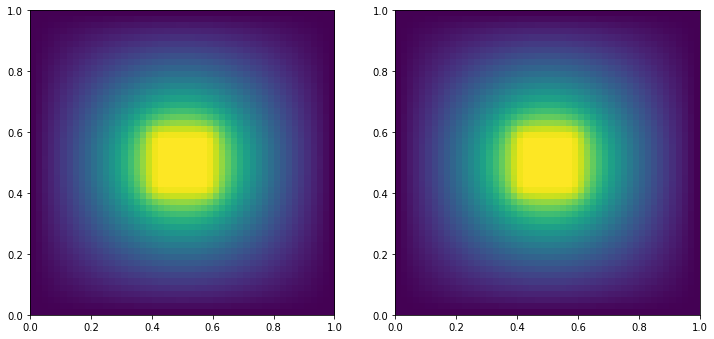

In [38]:
#
# Take a look at the convergence: this takes quite a while to run!
#
phi = []
for iter in [1024,2048]:
    phi.append( solve(iter) )
pmin,pmax = 0.0,1.0
# Now show the solution for a several different numbers of iterations.
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(phi[0].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)
ax[1].imshow(phi[1].T,origin='lower',extent=[0,1,0,1],vmin=pmin,vmax=pmax)
#
# Note the "rounded edges" for Phi!
#

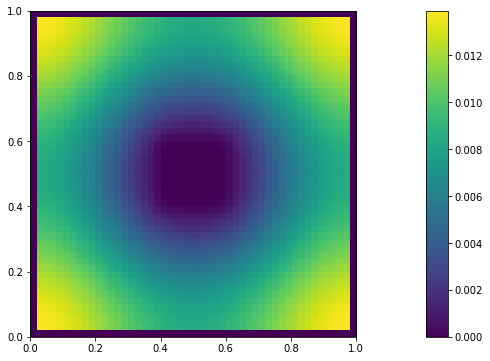

In [39]:
# Let's plot the fractional difference between the last two iterations:
ratio  = np.abs(phi[-1]-phi[-2])/phi[-1].clip(1e-3,1e3)
#
fig,ax = plt.subplots(1,2,figsize=(8,6),gridspec_kw={'width_ratios':[5,1]})
im = ax[0].imshow(ratio.T,origin='lower',extent=[0,1,0,1])
plt.colorbar(im,cax=ax[-1])
ax[-1].set_aspect(15)

So this is a very accurate measure of the potential.  Now we are in a position to compute the charges that lie on the inner and outer conductors and hence the capacitance for example.  Recall the surface charge density is $4\pi\sigma=\hat{n}\cdot\nabla\Phi$ so we would have $\sigma(0,0.5)\propto\Phi(h,0.5)-\Phi(0,0.5)$ for example.  Due to the 4-fold symmetry we really only need to do this along one side of each tube.

Text(0, 0.5, '$\\sigma$')

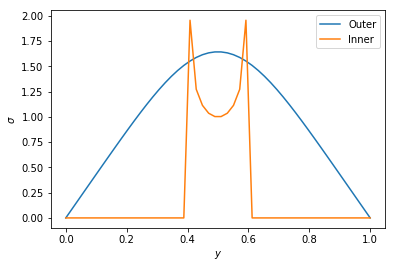

In [44]:
# Plot the surface charge density (up to a multiplicative constant) along the $y$-axis.
# We can do the gradient of the potential using centered differences or 1-sided differences,
# here I'll just use 1-sided to make the point.
Phi     = phi[-1]
sig_out = (Phi[ 1,:] - Phi[ 0,:])/(X[ 1,:]-X[ 0,:])
sig_inn = (Phi[20,:] - Phi[21,:])/(X[20,:]-X[21,:])
sig_inn[(Y[0,:]<0.4)|(Y[0,:]>0.6)]=0.0
#
fig,ax = plt.subplots(1,1)
ax.plot(Y[0,:],sig_out,label='Outer')
ax.plot(Y[0,:],sig_inn,label='Inner')
ax.legend()
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$\sigma$')

If we now integrated this charge density up we would get the charge (per unit length in the $z$ direction) and since we know the potential difference is 1 unit we could get the capacitance.  Or we could look at the maximum electric field for example.  Since this is a numerical approach, it is relatively easy now to introduce a deformation in the boundary or a source or defect, etc.